# Analysis of *in vivo* enzymatic data

This notebook is part of Supporting information of the following publication:
> reference

### Content

- Processing functions
- CrtI from *Xanthophyllomyces dendrorhous*

## Processing functions

In [1]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pandas as pd

def simulate(x, p):
    vmax = p['vmax'].value
    km = p['km'].value
    return vmax * x / (km + x)

def residual(p, x, data):
    return (data - simulate(x, p))

def fit_data(x, y):
    
    p = lmfit.Parameters()
    p.add('vmax', value=1., min=0.)
    p.add('km', value=1., min=0.)
    
    # create Minimizer
    mini = lmfit.Minimizer(residual, params=p, fcn_args=(x, y))
    
    # first solve with Nelder-Mead algorithm
    out = mini.minimize(method='leastsq')
    
    mini.minimize()

    return out, mini

def monte_carlo(x, y, n_iter=100):

    out, _ = fit_data(x, y)
    out_sim = simulate(x, out.params)
    
    x_sim = np.arange(0, np.max(x), np.max(x)/200)
    y_sim = simulate(x_sim, out.params)
    
    noise = np.mean(np.abs(out.residual))
    
    res_mc_sim = np.empty([n_iter, y_sim.size])
    res_mc_par = np.empty([n_iter, 2])
    
    for i in range(n_iter):
        data_noise = np.random.normal(out_sim, [noise]*y.size)
        data_noise[data_noise < 0] = 0
        out_mc, _ = fit_data(x, data_noise)
        res_mc_sim[i,] = simulate(x_sim, out_mc.params)
        res_mc_par[i,] = [out_mc.params['vmax'].value, out_mc.params['km'].value]
    
    ci_sim = np.empty([2, y_sim.size])
    ci_sim[0,] = np.percentile(res_mc_sim, 5, axis=0)
    ci_sim[1,] = np.percentile(res_mc_sim, 95, axis=0)

    # calculate statistics (mean, median, sd, rsd, CI_0.05, CI_0.95) 
    ci_par = {'best fit': [out.params['vmax'].value, out.params['km'].value],
              'mean': np.mean(res_mc_par, axis=0),
              'median': np.median(res_mc_par, axis=0),
              'sd': np.std(res_mc_par, axis=0),
              'rsd': np.std(res_mc_par, axis=0)/np.mean(res_mc_par, axis=0),
              'lower bound (95% ci)': np.percentile(res_mc_par, 5, axis=0), 
              'upper bound (95% ci)': np.percentile(res_mc_par, 95, axis=0)} 
    ci_par = pd.DataFrame(ci_par, index=['vmax', 'km']) 
    
    return ci_sim, ci_par

def plot_results(x, y, mini, out, results_mc, save=None, plot=dict(), plot_args=dict(), plot_sim=dict()):
    
    # plot confidence intervals (a1 vs t2 and a2 vs t2)
    fig, axes = plt.subplots(1, 2, **plot)
    
    x_sim = np.arange(0, np.max(x), np.max(x)/200)
    y_sim =  simulate(x_sim, out.params)
    
    axes[0].fill_between(x_sim, results_mc[0,], results_mc[1,], color="#EF553B", alpha=0.3)
    
    axes[0].plot(x, y, 'o', markersize=5, label='data', **plot_args)
    axes[0].plot(x_sim, y_sim, label='best fit (95% CI)', **plot_sim)
    axes[0].set_xlabel('concentration')
    axes[0].set_ylabel('flux')
    axes[0].legend()
    
    try:
        cx, cy, grid = lmfit.conf_interval2d(mini, out, 'vmax', 'km', 50, 50)
        ctp = axes[1].contourf(cx, cy, grid, np.linspace(0, 1, 11))
        fig.colorbar(ctp, ax=axes[1])
        axes[1].set_xlabel('vmax')
        axes[1].set_ylabel('km')
    except:
        pass

    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()


# CrtB

## CrtB with promoter PG1P

In [2]:
# GGPP concentration
CrtB_pg1p_GGPP = np.float_([3.907106439, 5.975574554, 5.515914973, 22.98297905, 27.57957486, 32.17617068, 75.84383088, 96.52851203, 71.24723507, 78.14212878, 73.54553297, 96.52851203, 183.8638324, 156.2842576, 170.074045, 87.3353204, 204.5485136, 211.4434073, 2.298297905, 2.298297905, 2.298297905, 91.93191622, 85.0370225, 64.35234135, 4.596595811, 2.298297905, 2.298297905, 87.3353204, 71.24723507, 50.56255392, 4.13693623, 4.36676602, 4.596595811, 1.149148953, 2.987787277, 2.987787277, 3.447446858, 2.757957486, 2.068468115, 2.757957486, 1.838638324, 3.447446858, 1.608808534, 0.689489372])
# phytoene flux
CrtB_pg1p_phytoene_flux = np.float_([3.764611969, 4.343783041, 4.428820064, 84.00278844, 55.15914973, 80.04971604, 252.8127696, 247.0670248, 232.587748, 289.5855361, 306.3631108, 286.8275786, 384.2754098, 424.0359635, 432.0800062, 427.94307, 418.2902188, 433.6888147, 1.790374068, 2.167294925, 3.298057494, 250.9741313, 231.6684289, 222.0155777, 9.14033077, 7.632647344, 7.161496273, 250.9741313, 270.2798337, 164.0984704, 22.20155777, 19.78834497, 25.74093654, 1.530666405, 17.37513216, 14.84700447, 19.21377049, 14.34137893, 8.50370225, 14.45629382, 17.0074045, 16.54774492, 1.406558318, 1.902990666])


In [3]:
# fit data
results, mini = fit_data(CrtB_pg1p_GGPP, CrtB_pg1p_phytoene_flux)

# calculate confidence intervals on the fit
ci_sim, ci_par = monte_carlo(CrtB_pg1p_GGPP, CrtB_pg1p_phytoene_flux, n_iter=1000)

Show results.

In [4]:
results

In [5]:
ci_par

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,798.254283,796.959839,795.627379,61.022000,0.076568,704.513619,896.395983
km,165.332791,164.801640,163.969401,21.295343,0.129218,131.618719,200.018038


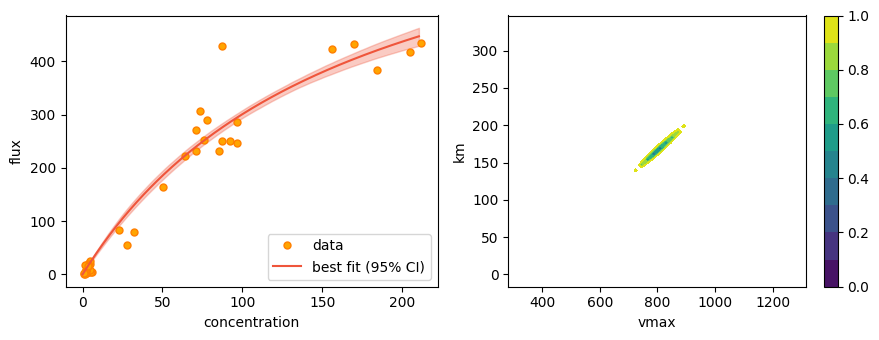

In [6]:
plot_results(CrtB_pg1p_GGPP, CrtB_pg1p_phytoene_flux, mini, results, ci_sim,
             save="./figures/CrtB_pg1p.svg",
             plot=dict(figsize=(9, 3.5)),
             plot_args=dict(markerfacecolor="#FFA500", markeredgewidth=1, markeredgecolor="#FF7F00"),
             plot_sim=dict(color="#EF553B")) 

In [7]:
np.mean(np.abs(results.residual))

19.67537956953282

## CrtB with promoter TEF1

In [8]:
# GGPP concentration
CrtB_tef1_GGPP = np.float_([8.273872459, 5.975574554, 5.745744763, 34.47446858, 34.47446858, 32.17617068, 119.5114911, 87.3353204, 91.93191622, 163.1791513, 89.63361831, 96.52851203, 199.9519178, 117.2131932, 229.8297905, 344.7446858, 252.8127696, 298.7787277, 2.298297905, 0, 2.298297905, 218.338301, 117.2131932, 209.1451094])
# phytoene flux
CrtB_tef1_phytoene_flux = np.float_([3.281969409, 1.544456192, 1.507683426, 9.882680993, 11.6293874, 11.88220017, 25.69497058, 25.37320888, 24.70670248, 44.47206447, 47.52880068, 54.35474546, 17.03038748, 0, 31.46369832, 22.33945564, 22.66121735, 22.33945564, 1.790374068, 3.015366852, 2.167294925, 53.09068161, 58.88239234, 55.98653698])


In [9]:
# fit data
results, mini = fit_data(CrtB_tef1_GGPP, CrtB_tef1_phytoene_flux)

# calculate confidence intervals on the fit
ci_sim, ci_par = monte_carlo(CrtB_tef1_GGPP, CrtB_tef1_phytoene_flux, n_iter=1000)

Show results.

In [10]:
results

In [11]:
ci_par

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,41.029221,42.004013,40.497703,9.246842,0.220142,31.097616,57.222756
km,40.671575,45.668000,34.471974,41.575665,0.910389,10.100470,113.587359


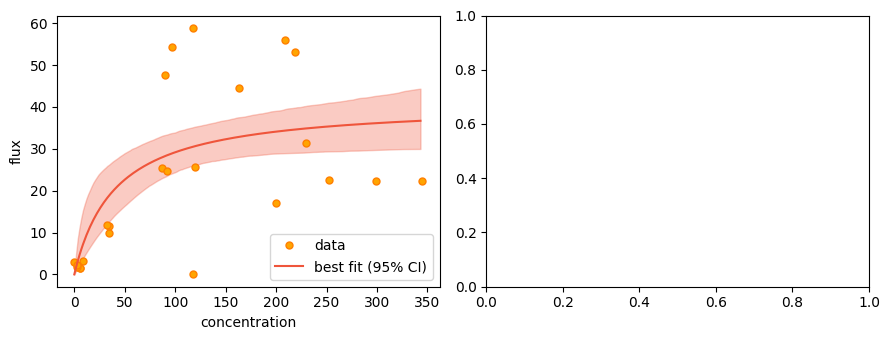

In [12]:
plot_results(CrtB_tef1_GGPP, CrtB_tef1_phytoene_flux, mini, results, ci_sim,
             save="./figures/CrtB_tef1.svg",
             plot=dict(figsize=(9, 3.5)),
             plot_args=dict(markerfacecolor="#FFA500", markeredgewidth=1, markeredgecolor="#FF7F00"),
             plot_sim=dict(color="#EF553B")) 

In [13]:
np.mean(np.abs(results.residual))

11.031424680467358

# Phytoene desaturase - CrtI

## CrtI from *Xanthophyllomyces dendrorhous*

In [14]:
# phytoene concentration
XdCrtI_phytoene = np.float_([944.7255309, 943.038521, 0.421752469, 1.265257407, 2046.34298, 1749.850995, 1582.415264, 1486.255701, 261.9082833, 302.3965204, 949.7865605, 892.8499772, 0, 0, 0, 985.2137679, 951.0518179, 857.4227698, 1767.564598, 1795.400261, 1735.933163, 911.8288383, 1726.232856, 1609.407422, 208.7674722, 203.7064426, 203.2846901, 285.1046691, 292.2744611, 315.8925994, 49.34503889, 50.18854383, 48.07978148, 266.969313, 237.4466401, 233.2291154, 1.687009877, 2.952267284, 0, 1603.92464, 1679.840085, 1741.837698, 1290.562556, 1308.697912, 1159.397538, 384.6382519, 419.6437068, 740.1755834, 698.0003364, 782.3508303, 202.4411852, 202.0194327, 204.1281951, 296.4919858, 254.7384914, 250.0992142, 46.81452408, 44.28400926, 45.1275142, 233.6508679, 260.6430259, 237.0248877])
# lycopene flux
XdCrtI_lycopene_flux = np.float_([124.7965487, 120.7719585, 1.258754814, 1.198814109, 178.452043, 167.7740345, 135.4831202, 105.4271379, 102.8668135, 116.2079019, 138.6428517, 114.4524955, 2.012295111, 1.695465668, 1.507080594, 122.2447872, 139.1480662, 128.0333468, 136.3222901, 126.0981183, 139.7217844, 123.2894681, 172.0298246, 128.5728132, 54.33196799, 40.99944251, 48.16663829, 84.27663184, 93.17354511, 85.1586165, 16.01701279, 24.75122986, 15.2420651, 55.78338936, 58.76329872, 61.65329702, 2.106487648, 3.159731472, 2.63310956, 105.3243824, 109.5373577, 114.2769549, 139.379266, 123.0539868, 120.9474991, 76.00909597, 85.48829038, 102.1646509, 100.0581633, 107.0797888, 46.34272826, 46.51826889, 46.86935017, 73.90260832, 73.20044577, 76.53571788, 22.46920158, 20.53825457, 21.94257967, 52.31110993, 58.80611351, 53.01327247])

In [15]:
# fit data
results, mini = fit_data(XdCrtI_phytoene, XdCrtI_lycopene_flux)

# calculate confidence intervals on the fit
ci_sim, ci_par = monte_carlo(XdCrtI_phytoene, XdCrtI_lycopene_flux, n_iter=1000)

Show results.

In [16]:
results

In [17]:
ci_par

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,168.412320,168.478389,168.293378,5.429796,0.032228,159.716046,177.861875
km,379.863544,380.973813,378.225950,36.859928,0.096752,322.341530,447.132452


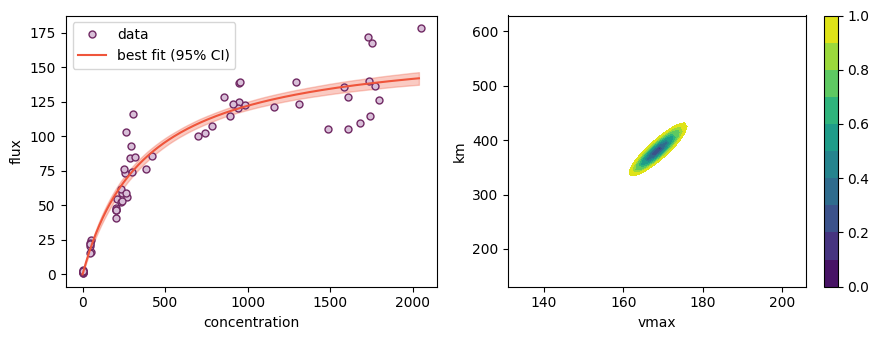

In [18]:
plot_results(XdCrtI_phytoene, XdCrtI_lycopene_flux, mini, results, ci_sim,
             save="./figures/XdCrtI.svg",
             plot=dict(figsize=(9, 3.5)),
             plot_args=dict(markerfacecolor="#D8BFD8", markeredgewidth=1, markeredgecolor="#702963"),
             plot_sim=dict(color="#EF553B")) 

## CrtI from *Pantoea ananatis*

In [19]:
# phytoene concentration
PaCrtI_phytoene = np.float_([940.0862537, 1005.457886, 4.639277161, 4.217524692, 1449.563236, 1490.473226, 1414.557782, 1200.307527, 338.2454803, 376.2032025, 944.3037784, 829.5871068, 5.904534568, 7.591544445, 5.482782099, 1080.108073, 1053.95942, 1045.102619, 2150.937593, 2016.820307, 1961.148982, 1889.029309, 1835.044993, 1789.495727, 6.748039506, 5.06102963, 7.169791976, 1790.339232, 1681.527095, 1814.379122, 482.9065772, 517.9120321, 499.7766759, 0, 924.0596599, 1058.598698])
# lycopene flux
PaCrtI_lycopene_flux = np.float_([4.795256435, 4.564056571, 0, 0, 6.182455617, 6.679107177, 4.795256435, 3.930397685, 2.115050606, 2.63310956, 4.212975296, 3.510812747, 0.184103595, 0, 0.141288806, 7.278514231, 7.762321353, 8.091995233, 12.66461476, 10.93061578, 15.64452412, 10.94346022, 11.09759346, 8.151935939, 0.175540637, 0.175540637, 0.175540637, 16.67636055, 16.14973863, 17.02744182, 10.18135697, 10.3568976, 11.23460079, 0, 7.723788043, 8.601491229])

In [20]:
# fit data
results, mini = fit_data(PaCrtI_phytoene, PaCrtI_lycopene_flux)

# calculate confidence intervals on the fit
ci_sim, ci_par = monte_carlo(PaCrtI_phytoene, PaCrtI_lycopene_flux, n_iter=1000)

Show results.

In [21]:
results

In [22]:
ci_par

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,40.538440,3.702805e+06,41.914364,2.563444e+07,6.922978,21.027679,2736.645017
km,4525.962909,5.540618e+08,4734.781348,3.821449e+09,6.897154,1668.764721,408185.675951


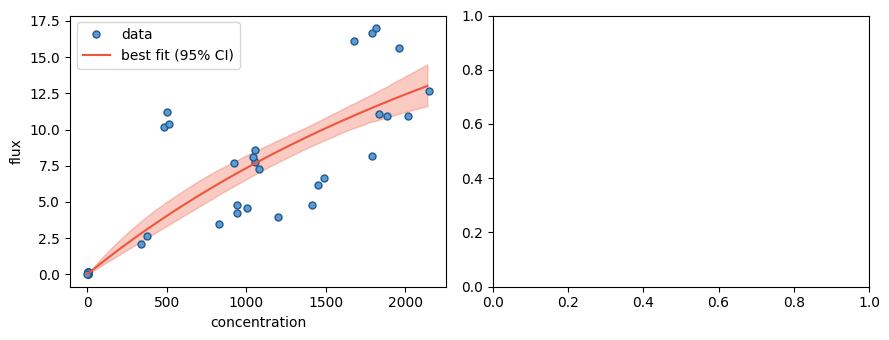

In [23]:
plot_results(PaCrtI_phytoene, PaCrtI_lycopene_flux, mini, results, ci_sim,
             save="./figures/PaCrtI.svg",
             plot=dict(figsize=(9, 3.5)),
             plot_args=dict(markerfacecolor="#5B9BD5", markeredgewidth=1, markeredgecolor="#225A8C"),
             plot_sim=dict(color="#EF553B")) 

## CrtI from *Blakeslea trispora*

In [24]:
# phytoene concentration
BtCrtI_phytoene = np.float_([131.727241, 128.376673, 140.9624604, 1.14751E-09, 1.545E-09, 1.28845E-09, 270.4091402, 265.4437431, 272.6291353, 50.03955335, 49.05029091, 47.59516895, 30.54421679, 30.41858266, 30.57607821, 4.541108677, 5.779208569, 6.72363256, 32.1748014, 19.10687785, 17.11841606])
# lycopene flux
BtCrtI_lycopene_flux = np.float_([150.2134076, 173.5066181, 160.5264066, 3.705120561, 4.365261324, 3.663334936, 181.1899148, 168.9607416, 181.8598984, 145.034209, 176.0572964, 176.4256061, 138.7856271, 133.8630367, 124.7765728, 35.58741875, 64.09769602, 67.95531019, 112.1598656, 63.95561369, 56.43122617])

In [25]:
# fit data
results, mini = fit_data(BtCrtI_phytoene, BtCrtI_lycopene_flux)

# calculate confidence intervals on the fit
ci_sim, ci_par = monte_carlo(BtCrtI_phytoene, BtCrtI_lycopene_flux, n_iter=1000)

Show results.

In [26]:
results

In [27]:
ci_par

,best fit,mean,median,sd,rsd,lower bound (95% ci),upper bound (95% ci)
vmax,191.242238,191.280215,191.276278,7.322926,0.038284,178.880927,203.407452
km,16.930062,16.970925,16.832722,2.560964,0.150903,12.957671,21.369493


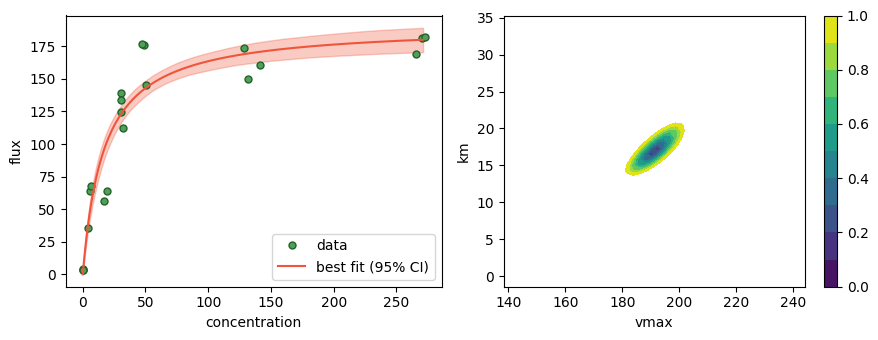

In [28]:
plot_results(BtCrtI_phytoene, BtCrtI_lycopene_flux, mini, results, ci_sim,
             save="./figures/BtCrtI.svg",
             plot=dict(figsize=(9, 3.5)),
             plot_args=dict(markerfacecolor="#4fA15A", markeredgewidth=1, markeredgecolor="#23612B"),
             plot_sim=dict(color="#EF553B")) 